<a href="https://colab.research.google.com/github/noneotherthanmodi/GANs/blob/main/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

170498071/170498071 [==============================] - 4s 0us/step


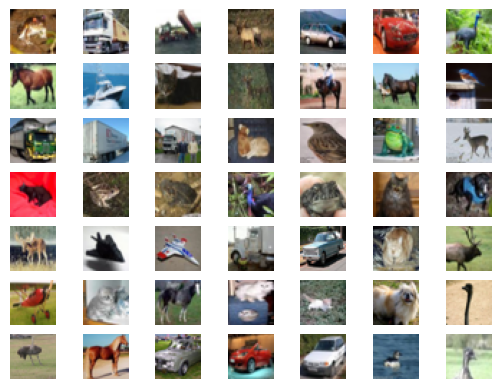

In [12]:
import keras
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot as plt
(trainx,trainy),(testx,testy) = load_data()

for i in range(49):
  plt.subplot(7,7,1+i)
  plt.axis('off')
  plt.imshow(trainx[i])

plt.show()

In [13]:
print(trainx.shape)
print(trainy.shape)
print(testx.shape)
print(testy.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [14]:
from keras.models import Sequential
from keras import utils
from keras.layers import Conv2D, Conv2DTranspose, Dense,Flatten,Dropout,LeakyReLU
# from python.keras.utils import vis_utils
# from keras_vis.utils import vis_utils
# from keras.utils.vis_utils import plot_model
import numpy as np
from keras.optimizers import Adam

In [15]:
#creating model for discriminator: (which will give 0 or 1 as output as it is a binary classifier)
def define_discriminator(in_shape=(32,32,3)):
  model = Sequential()
  model.add(Conv2D(64,(3,3),padding='same',input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  #downsample
  model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #downsample
  model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #downsample
  model.add(Conv2D(256,(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #classifier
  model.add(Flatten())
  model.add(Dropout(0.3))
  model.add(Dense(1,activation='sigmoid'))

  #compile the model
  opt = Adam(lr=0.0002,beta_1=0.5)
  model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

  #return the model
  return model

In [16]:
model = define_discriminator()
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 256)        

In [17]:
#function to load real dataset for training, that's why we just need trainx and will not focus on trainy...
def load_real_data():
  (trainx,_),(_,_) = load_data()
  #convert from unsigned to float
  X = trainx.astype('float32')
  #scaling from [0,255] in the range of [-1,1]
  X = (X-127.5) / 127.5
  return X


In [18]:
X = load_real_data()
X.shape

(50000, 32, 32, 3)

In [19]:
#WE CAN'T GIVE 50000 IMAGES TO THE DISCRIMINATOR, SO WE WILL
#GIVE IMAGES IN THE BATCHES OF 128 (64-FAKES,64-REAL) IMAGES

In [20]:
#select real samples
def generate_real_samples(dataset,n_samples):    #it will take the dataset of 50k images and will ask for no of samples which will be 64(only real ones here)
  #choose random instances
  ix = np.random.randint(0,dataset.shape[0],n_samples)
  #retrieve selected images
  X = dataset[ix]
  #generate 'real' class labels(1)
  y = np.ones((n_samples,1))     #it will send 64 images and it will label them as 1
  return X,y    #X is basically the dataset of images and y is the labeling as '1'


In [21]:
X,y = generate_real_samples(X,64)
print(X.shape)   #X is no of images with the shape n size(32,32) and 3 for rgb (64,32,32,3)
print(y.shape)   #SHAPE of y is only the images with the labeling  (64,1)
print(y)         #y contains only the true value that is '1'

(64, 32, 32, 3)
(64, 1)
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [22]:
#GENERATE FAKE SAMPLES
def generate_fake_samples(n_samples):   #it just generates the fake samples thats why only one input is given that is how many fake samples do you need?
  #generate random uniform numbers in [0,1]
  X = np.random.rand(32 * 32 * 3 * n_samples)
  #bring this in the range of [-1,1]
  X = -1 + X * 2
  #reshape it in the input format
  X = X.reshape((n_samples,32,32,3))

  #label fake images as 0
  y = np.zeros((n_samples,1))
  return X,y


In [23]:
X,y = generate_fake_samples(64)
print(X.shape)
print(y.shape)
print(y)

(64, 32, 32, 3)
(64, 1)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


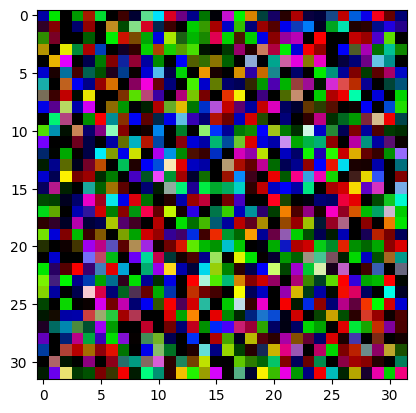

In [24]:
plt.imshow(X[0])

In [25]:
#train the discriminator model temporarily
def train_discriminator(model,dataset,iterations=20,n_batch=128):
  half_batch = int(n_batch/2)
  for i in range(iterations):
    #get real samples
    X_real,y_real = generate_real_samples(dataset,half_batch)
    #update disciminator on real samples:
    _,real_acc = model.train_on_batch(X_real,y_real)
    #generate fake samples:
    X_fake,y_fake = generate_fake_samples(half_batch)
    #update disciminator on fake samples:
    _, fake_acc = model.train_on_batch(X_fake,y_fake)
    #print performance:
    print("->%d real=%.0f%% fake=%.0f%%" % (i+1, real_acc*100, fake_acc*100))

In [26]:
#define the discriminator model:
model = define_discriminator()

#load image data
dataset = load_real_data()

#fit in the model:
train_discriminator(model,dataset)

->1 real=83% fake=0%
->2 real=98% fake=0%
->3 real=94% fake=78%
->4 real=91% fake=100%
->5 real=97% fake=100%
->6 real=95% fake=100%
->7 real=98% fake=100%
->8 real=98% fake=100%
->9 real=100% fake=100%
->10 real=100% fake=100%
->11 real=100% fake=100%
->12 real=100% fake=100%
->13 real=100% fake=100%
->14 real=100% fake=100%
->15 real=100% fake=100%
->16 real=100% fake=100%
->17 real=100% fake=100%
->18 real=100% fake=100%
->19 real=100% fake=100%
->20 real=100% fake=100%


In [27]:
from keras.models import Sequential
from keras.layers import Conv2DTranspose,Reshape


In [28]:
def define_generator(latent_dim):
  model = Sequential()
  #4x4 image
  n_nodes = 256 * 4 * 4
  model.add(Dense(n_nodes,input_dim = latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4,4,256)))
  #upsampling to 8x8
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))   #strides convert 8x8 to 16x16 because of upsampling.
  model.add(LeakyReLU(alpha=0.2))
  #upsampling to 16x16
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #upsampling to 32x32
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  #output layer:
  model.add(Conv2D(3,(3,3),activation='tanh',padding='same'))      #first 3 denotes that image is now of 32x32x3
  return model


In [29]:
latent_dim = 100
model = define_generator(latent_dim)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 8, 8, 128)         524416    
 Transpose)                                                      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 16, 16, 128)       262272    
 Transpose)                                           

In [30]:
def generate_latent_points(latent_dim,n_samples):
  #generate points to the latent space:
  x_input = np.random.randn(latent_dim * n_samples)
  #reshape the points:
  x_input = x_input.reshape(n_samples,latent_dim)
  return x_input

In [31]:
a = generate_latent_points(100,64)      #we will give 64, 100 dimensional points to the generator, and in return it will give 64, 32x32x3 images
a.shape       #and will give that 64 images to the discriminator along with the real data


(64, 100)

In [32]:
def generate_fake_samples(g_model,latent_dim,n_samples):
  #generate latent points
  x_input = generate_latent_points(latent_dim,n_samples)
  #predict output:
  X = g_model.predict(x_input)
  #label the fake datas as 0
  y = np.zeros((n_samples,1))
  return X,y

2/2 [==============================] - 1s 205ms/step


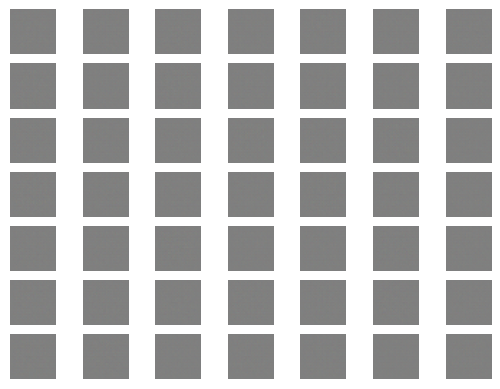

In [34]:
#size of the latent_dim
latent_dim = 100
#define the generator model:
model = define_generator(latent_dim)
#generate samples:
n_samples = 49
X,_ = generate_fake_samples(model,latent_dim,n_samples)
#scale pixel values from [-1,1] to [0,1]
X = (X+1)/2.0
#plot the generated fake images:     (right now it will generate a simple gray images, caz it is not getting the response from discriminator and feeding again to the generator)
for i in range(n_samples):
  #define subplot
  plt.subplot(7,7,1+i)
  plt.axis('off')
  plt.imshow(X[i])
plt.show()


In [4]:
def define_gan(g_model,d_model):
  #make the weights in the discriminator non-trainable:
  d_model.trainable = False
  #create a new overall model which will contain both the models:
  model = Sequential()
  model.add(g_model)
  model.add(d_model)
  opt = Adam(lr=0.0002,beta_1 = 0.5)
  model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
  return model

In [ ]:
#define latent dim:
latent_dim = 100
#create dis and gen models:
d_model = define_discriminator()
g_model= define_generator(latent_dim)

gan_model = define_gan(g_model,d_model)

gan_model.summary()


In [8]:
def train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs=200,n_batch=128):
  batch_per_epoch = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch/2)
  #manually enumerating epochs:
  for i in range(n_epochs):
    #enumerate batches over the training dataset:
    for j in range(batch_per_epoch):
      #get randomly selected real samples:
      X_real,y_real = generate_real_samples(dataset,half_batch)      #X_real will get 64,y_real will be the label that is 1

      #update discriminator over real samples:
      d_loss1, _ = d_model.train_on_batch(X_real,y_real)        # _ is the accuracy on real data

      #get fake datas:
      X_fake,y_fake = generate_fake_samples(g_model,latent_dim,half_batch)      #X_fake will get 64,y_fake will be the label that is 0

      #update discriminator model weights:
      d_loss2, _ = d_model.train_on_batch(X_fake,y_fake)   # _ is the accuracy on fake data

      #prepare points in latent space as input for generator
      X_gen = generate_latent_points(latent_dim,n_batch)

      #create inverted labels for fake data:
      y_gen = np.ones((n_batch,1))

      #update the generator via discriminator output:
      g_loss = gan_model.train_on_batch(X_gen,y_gen)

      #summarize loss in batch:
      print("-> %d, %d/%d, d1=%.3f,d2=%.3f g=%.3f"% (i+1,j+1,batch_per_epoch,d_loss1,d_loss2,g_loss))

    #evaluate the model performance:
    if (i+1) %10==0:
      summarize_performance(i,g_model,d_model,dataset,latent_dim)

In [7]:
def summarize_performance(epoch,g_model,d_model,latent_dim,n_samples=150):
  #prepare real samples:
  X_real,y_real = generate_real_samples(dataset,n_samples)
  #evaluate discriminator on real samples:
  _, acc_real = d_model.evaluate(X_real,y_real,verbose = 0)
  #prepare fake samples;
  X_fake,y_fake = generate_fake_samples(g_model,latent_dim,n_samples)
  #evaluate discriminator on fake samples;
  _, acc_fake = d_model.evaluate(X_fake,y_fake,verbose = 0)

  print("-> Accuracy real: %0.f%%, fake: %0.f%%" % (acc_real*100, acc_fake*100))

  #save plot:
  save_plot(X_fake,epoch)
  filename = 'generator_model_%03d.h5' % (epoch+1)
  g_model.save(filename)


In [6]:
def save_plot(examples,epoch,n=7):
  #scale from [-1,1] to [0,1]
  examples = (examples + 1) / 2.0
  #plot images:
  for i in range(n * n):
    plt.subplot(n ,n ,1+i)
    plt.axis('off')
    plt.imshow(examples[i])

  filename = 'generated_plot_e%03d.png' % (epoch+1)
  plt.savefig(filename)
  plt.close()